In [1]:
import os
import sys
sys.path.append("/Users/xszpo/Google Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy/app_webscr_otodom")
import helpers

# run scrapy settings
%run /Users/xszpo/Google\ Drive/DataScience/Projects/201907_xFlat_AWS_Scrapy/app_webscr_otodom/scraper/settings.py


In [2]:
import gc


def load_raw_data(file_name_list, file_path, exclude_columns = ['gallery']):
    
    _dict = {}
    
    for name in file_name_list:
        # LOAD DATA
        _tmp = helpers.FilesLocal.read_file(file_path, name)
        _dict[name] = helpers.Scraper.dict_except(_tmp, exclude_columns)
    gc.collect()
    return _dict

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class PassThroughOrReplace(BaseEstimator, TransformerMixin):
    """
    Just pass data throught, !Rememeber to reset DF index before:
    * It will replace text or numeric values if dictionary is provided
      ex. replace_dict = {'column name':{'old value':'new value'}}
    * It will fill na if fillna is True, text with 'novalue', numeric with mean
    """

    def __init__(self, replace_dict=None, fillna=False, **kwargs):
        self.replace_dict = replace_dict
        self.fillna = fillna
        self.kwargs = kwargs

    def fit(self, x, y=None):

        new_x = x.copy()

        if type(new_x) == pd.core.frame.DataFrame:

            self.f_category = list(new_x.select_dtypes(
                include=['object']).columns)
            self.f_numeric = list(new_x.select_dtypes(
                exclude=['object']).columns)
            self.f_date = list(new_x.select_dtypes(
                    include=['datetime64[ns]']).columns)

        if type(new_x) == pd.core.series.Series:

            self.f_category = list(new_x.to_frame().select_dtypes(
                include=['object']).columns)
            self.f_numeric = list(new_x.to_frame().select_dtypes(
                exclude=['object']).columns)
            self.f_date = list(new_x.to_frame().select_dtypes(
                include=['datetime64[ns]']).columns)

        if self.replace_dict:
            if type(new_x) == pd.core.frame.DataFrame:
                new_x.replace(self.replace_dict, inplace=True)

            if type(new_x) == pd.core.series.Series:
                new_x = new_x.to_frame().replace(self.replace_dict).iloc[:, 0]

        if type(new_x) == pd.core.frame.DataFrame:
            self.columnNames = new_x.columns
            self.means = pd.DataFrame.from_dict(
                {"column": new_x[self.f_numeric].mean().index,
                "mean": new_x[self.f_numeric].mean()}).to_dict(orient='index')

        if type(new_x) == pd.core.series.Series:
            self.columnNames = [new_x.name]
            self.means = {new_x.name: {"column": new_x.name, 
                                        "mean": new_x.mean()}}

        return self

    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None

    def transform(self, x):

        new_x = x.copy()

        if self.replace_dict:
            if type(new_x) == pd.core.frame.DataFrame:
                new_x.replace(self.replace_dict, inplace=True)

            if type(new_x) == pd.core.series.Series:
                new_x = new_x.to_frame().replace(self.replace_dict).iloc[:, 0]

        if self.fillna:
            if len(self.f_category) > 0:
                #new_x.replace({'': np.nan}, inplace=True)
                new_x.fillna('novalue', inplace=True)

            if len(self.f_numeric) > 0 and type(new_x) == pd.core.frame.DataFrame:
                for col in self.f_numeric:
                    new_x[col] = new_x[col].fillna(self.means[col]["mean"])

            if len(self.f_numeric) > 0 and type(new_x) == pd.core.series.Series:
                new_x = new_x.fillna(self.means[x.name]["mean"]).to_frame()

        return new_x

In [5]:
import unidecode
import re
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class transformColList(BaseEstimator, TransformerMixin):
    """
    Transform columns of Data Frame 
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs
        
    def __correct_names(self, x):
        x = unidecode.unidecode(x)
        x = re.sub("[_.,/ ~!@#$%^&*()-+]","_",x)
        x = re.sub("_+","_",x)
        x = x.lower()
        return x

    def fit(self, x, y=None):
        
        if type(x) == pd.core.frame.DataFrame:
            self.columns = x.columns
            self.cor_values = {}
            self.columnNames = []
            #df
            for col in self.columns:
                if type(x[col][0])==list:
                    self.cor_values[col] = set([(item,col+"_"+self.__correct_names(item)) for sublist in x[col].values for item in sublist if item != ''])
                    self.columnNames += [i[1] for i in self.cor_values[col]]
                else:
                    self.cor_values[col] = [(item,col+"_"+self.__correct_names(item)) for item in list(x[col].unique()) if item is not None]
                    self.columnNames += [i[1] for i in self.cor_values[col]]

        if type(x) == pd.core.series.Series:
            self.columns = [x.name]
            self.cor_values = {}
            #ser
    
            for col in self.columns:
                if type(x.to_list()[0])==list:
                    self.cor_values[col] = set([(item,col+"_"+self.__correct_names(item)) for sublist in x.values for item in sublist if item != ''])
                    self.columnNames = [i[1] for i in self.cor_values[col]]
                else:
                    self.cor_values[col] = [(item,col+"_"+self.__correct_names(item)) for item in list(x.unique()) if item is not None]
                    self.columnNames = [i[1] for i in self.cor_values[col]]

        return self 

    def get_feature_names(self):
        if hasattr(self, "columnNames"):
            return self.columnNames
        else:
            return None

    def transform(self, x):
                
        data = {}
        for i in self.columns:
            data[i] = []
            
        if type(x) == pd.core.frame.DataFrame:
            #df
            for col in self.columns:
                if type(x[col][0])==list:
                    
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for i,row in enumerate(x[col].tolist()):
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] in row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]
                    
                else:
                                       
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for row in x[col].tolist():
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] == row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]         
                
            return pd.concat([pd.DataFrame(data[i]) for i in data],axis=1)
                    
                                      
        if type(x) == pd.core.series.Series:
            #series
            for col in self.columns:
                if type(x[0])==list:
                    
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for i,row in enumerate(x.tolist()):
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] in row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]
                    
                else:
                                       
                    _dict = {}
                    
                    for i in self.cor_values[col]:
                        _dict[i[1]] = 0

                    for row in x.tolist():
                        _dict_tmp = _dict.copy()
                        for val in self.cor_values[col]:
                            if val[0] == row:
                                _dict_tmp[val[1]] = 1
                            else:
                                _dict_tmp[val[1]] = 0
                        data[col] += [_dict_tmp]         
                
            return pd.concat([pd.DataFrame(data[i]) for i in data],axis=1)
    

In [6]:
ID_list = [i[:-5] for i in os.listdir(LOCAL_DATA_PATH) if i.endswith(".bson")]

In [7]:
%%time
columns_2_exclude = ['gallery','img_gallery_strimg','GC_boundingbox','GC_addr_house_number','GC_addr_county','GC_addr_state','GC_addr_country','GC_addr_country_code']
raw_data = load_raw_data(ID_list, LOCAL_DATA_PATH, exclude_columns = columns_2_exclude)


CPU times: user 18.9 s, sys: 3.44 s, total: 22.3 s
Wall time: 26.2 s


In [8]:
import pandas as pd
pd.options.display.max_columns=99
pd.options.display.max_rows = 99

df = pd.DataFrame(raw_data.values())

In [9]:
import numpy as np
import pandas as pd

np.random.seed(666)
df['fold']=np.random.choice(['train', 'test'],df.shape[0],p=[0.9, 0.1]).tolist()

filter_query = "price <= 1000000 and price >= 10000 and flat_size <= 130 and property_form != 'udział'"
df_train = df[df['fold']=='train'].dropna(subset = ['price']).query(filter_query).reset_index(drop=True)
df_test = df[df['fold']=='test'].dropna(subset = ['price']).query(filter_query).reset_index(drop=True)

In [10]:
df_train.shape

(14329, 35)

In [11]:
df_test.shape

(1643, 35)

In [12]:
df_train.head(1)

,_id,flat_size,location,price,rooms,tracking_id,url,main_url,name,price_m2,market,building_type,floor,number_of_floors,building_material,widows_type,heating_type,year_of_building,finishing_stage,rent_price,property_form,available_from,description,additional_info,download_date,GC_latitude,GC_longitude,GC_addr_road,GC_addr_neighbourhood,GC_addr_suburb,GC_addr_city,GC_addr_postcode,floor_attic,floor_basement,fold
0,59686717_445000,45.0,"Warszawa, Praga-Północ, Siedlecka",445000.0,2,59686717,https://www.otodom.pl/oferta/metro-szwedzka-ce...,otodom.pl,Metro Szwedzka > cegła > po remoncie > 2 pokoje,9889.0,wtórny,kamienica,1.0,3.0,cegła,plastikowe,miejskie,1939.0,None,NaN,pełna własność,None,Nieruchomość 45m2 - 2 pokoje\nSalon - można w ...,"[telewizja kablowa, internet, telefon, balkon,...",1568468183,52.25773,21.054053,Siedlecka,Szmulowizna,Praga-Północ,Warszawa,03-768,0,0,train


In [13]:
df_train.columns

Index(['_id', 'flat_size', 'location', 'price', 'rooms', 'tracking_id', 'url',
       'main_url', 'name', 'price_m2', 'market', 'building_type', 'floor',
       'number_of_floors', 'building_material', 'widows_type', 'heating_type',
       'year_of_building', 'finishing_stage', 'rent_price', 'property_form',
       'available_from', 'description', 'additional_info', 'download_date',
       'GC_latitude', 'GC_longitude', 'GC_addr_road', 'GC_addr_neighbourhood',
       'GC_addr_suburb', 'GC_addr_city', 'GC_addr_postcode', 'floor_attic',
       'floor_basement', 'fold'],
      dtype='object')

In [14]:
target = 'price'

col_numeric = ['flat_size', 'floor_attic','floor_basement', 'rooms', 'floor', 'rent_price',
               'number_of_floors','year_of_building','GC_latitude','GC_longitude']

col_cat = ['additional_info','market' ,'building_type', 'building_material', 'widows_type',
          'heating_type', 'finishing_stage', 'property_form','GC_addr_postcode']

col_text = ['name', 'location','description']

OUT=['GC_boundingbox', 'GC_addr_house_number', 'GC_addr_road','GC_addr_neighbourhood', 'GC_addr_suburb',
       'GC_addr_city','GC_addr_county', 'GC_addr_state', 'GC_addr_postcode',
       'GC_addr_country', 'GC_addr_country_code', 'url', 'main_url']


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from category_encoders import TargetEncoder

import lightgbm as lgb

In [100]:
params = {'colsample_bytree': 0.6624318354159208, #feature_fraction
 'learning_rate': 0.15990411055449805,
 'max_bin': 38712,
 'max_depth': 7,
 'min_child_samples': 84, #min_data_in_leaf
 'min_child_weight': 6, #min_sum_hessian_in_leaf
 'n_estimators': 206, #num_iterations
 'num_leaves': 159,
 'reg_alpha': 3.960667919705787e-06, #lambda_l1
 'reg_lambda': 499.85995495490215, #lambda_l2
 'subsample': 0.9022680042341511, #bagging_fraction
 'subsample_for_bin': 144116, #bin_construct_sample_cnt
 'subsample_freq': 0 #bagging_freq
         } 

In [101]:
import numpy as np
seed = 666
np.random.seed(seed)

pipe_lgb = make_pipeline(
    ColumnTransformer([
        ('cat', transformColList(),col_cat),
        ('num', PassThroughOrReplace(),col_numeric),
        ('txt_dscr', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 3), 
                               max_features=3000, 
                               dtype=np.float32,
                               use_idf=True),'description'),
        ('txt_loc', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1,1), 
                               max_features=500, 
                               dtype=np.float32,
                               binary = True, 
                               use_idf=False),'location'),
        ('txt_name', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1,1), 
                               max_features=500, 
                               dtype=np.float32,
                               binary = True, 
                               use_idf=False),'name')
    ]),
    lgb.LGBMRegressor(**params, objective='regression_l2')
    )

In [102]:
%%time
y_log = np.log1p( df_train.price.tolist())
save = pipe_lgb.fit(df_train, y_log)

CPU times: user 1min 54s, sys: 5.98 s, total: 2min
Wall time: 1min 6s


In [103]:
#first pipe
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error

y_pred = pipe_lgb.predict(df_train)
y_pred = np.expm1(y_pred)
df_train['y_pred']=np.int32(y_pred.tolist())
df_train = df_train.assign(y_diff= lambda x: np.int32(x['price']-x['y_pred']))

r2 = r2_score(df_train.price, y_pred)
med_abs_err = median_absolute_error(df_train.price, y_pred)
mean_abs_err = mean_absolute_error(df_train.price, y_pred)
print("Train r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))

y_pred = pipe_lgb.predict(df_test)
y_pred = np.expm1(y_pred)
df_test['y_pred']=np.int32(y_pred.tolist())
df_test = df_test.assign(y_diff= lambda x: np.int32(x['price']-x['y_pred']))

r2 = r2_score(df_test.price, y_pred)
med_abs_err = median_absolute_error(df_test.price, y_pred)
mean_abs_err = mean_absolute_error(df_test.price, y_pred)

print("Test r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))


Train r2 score 0.9244, median absolute error 23626, mean absolute error 35129
Test r2 score 0.8947, median absolute error 27865, mean absolute error 41144


<IPython.core.display.Javascript object>


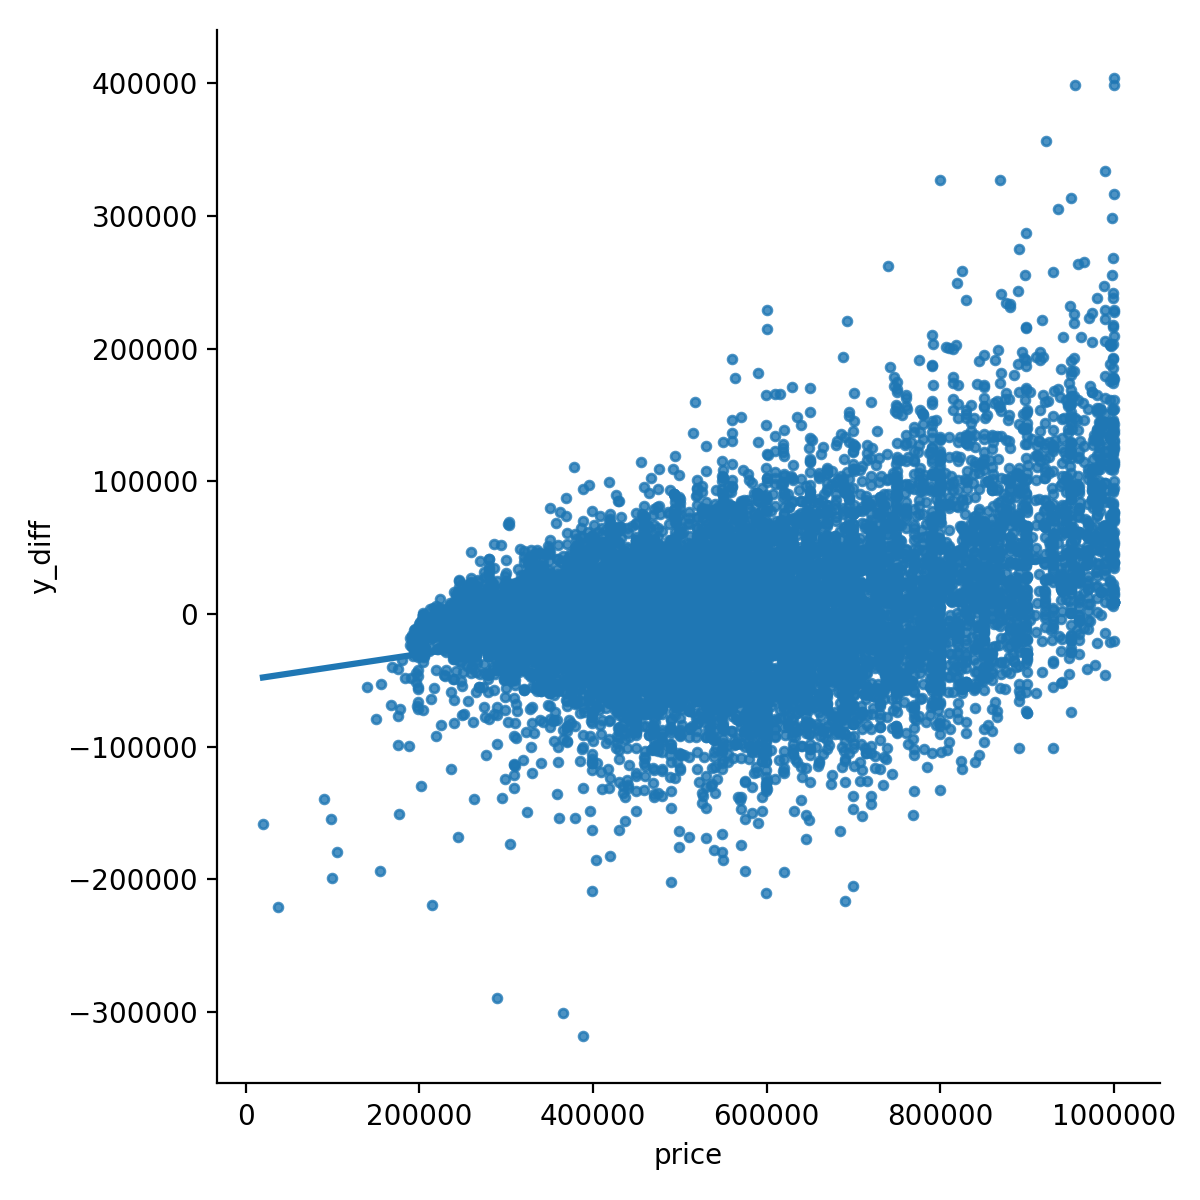

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

sns.lmplot(x='price', y='y_diff',data=df_train,
           order=1, ci=None, scatter_kws={"s": 10}, height=6, truncate=True);

In [105]:
#wyklucz = TBS

In [106]:
df_train.sort_values('y_diff')[['location','url','price','y_diff']].head(20).values

array([['Warszawa, Śródmieście, Czerniakowska',
        'https://www.otodom.pl/oferta/srodmiescie-apartament-na-wodzie-w-centrum-ID3NvAg.html#17e3a79e1d',
        389000.0, -317746],
       ['Warszawa, Ochota, Ochota, Sąchocka 7',
        'https://www.otodom.pl/oferta/w-pelni-wyposazone-mieszkanie-ochota-rakowiec-tbs-ID3ZkFK.html#4116e20c58',
        365000.0, -301078],
       ['Warszawa, Białołęka',
        'https://www.otodom.pl/oferta/mieszkanie-57-m2-plus-poddasze-ID42jTk.html#3ab264260c',
        289000.0, -289679],
       ['Warszawa, Białołęka, Odkryta',
        'https://www.otodom.pl/oferta/dom-z-bala-do-przeniesienia-sosna-syberyjska-ID42upS.html#6bc969168d',
        37000.0, -220693],
       ['Warszawa, Bemowo, ul. gen. Tadeusza Pełczyńskiego',
        'https://www.otodom.pl/oferta/mieszkanie-2-pokojowe-tbs-warszawa-bemowo-ID42cJZ.html#2b439c88db',
        215000.0, -219703],
       ['Warszawa, Śródmieście',
        'https://www.otodom.pl/oferta/centrum-90-5m2-3-pokoje-poddasz

Plotting feature importances...


<IPython.core.display.Javascript object>


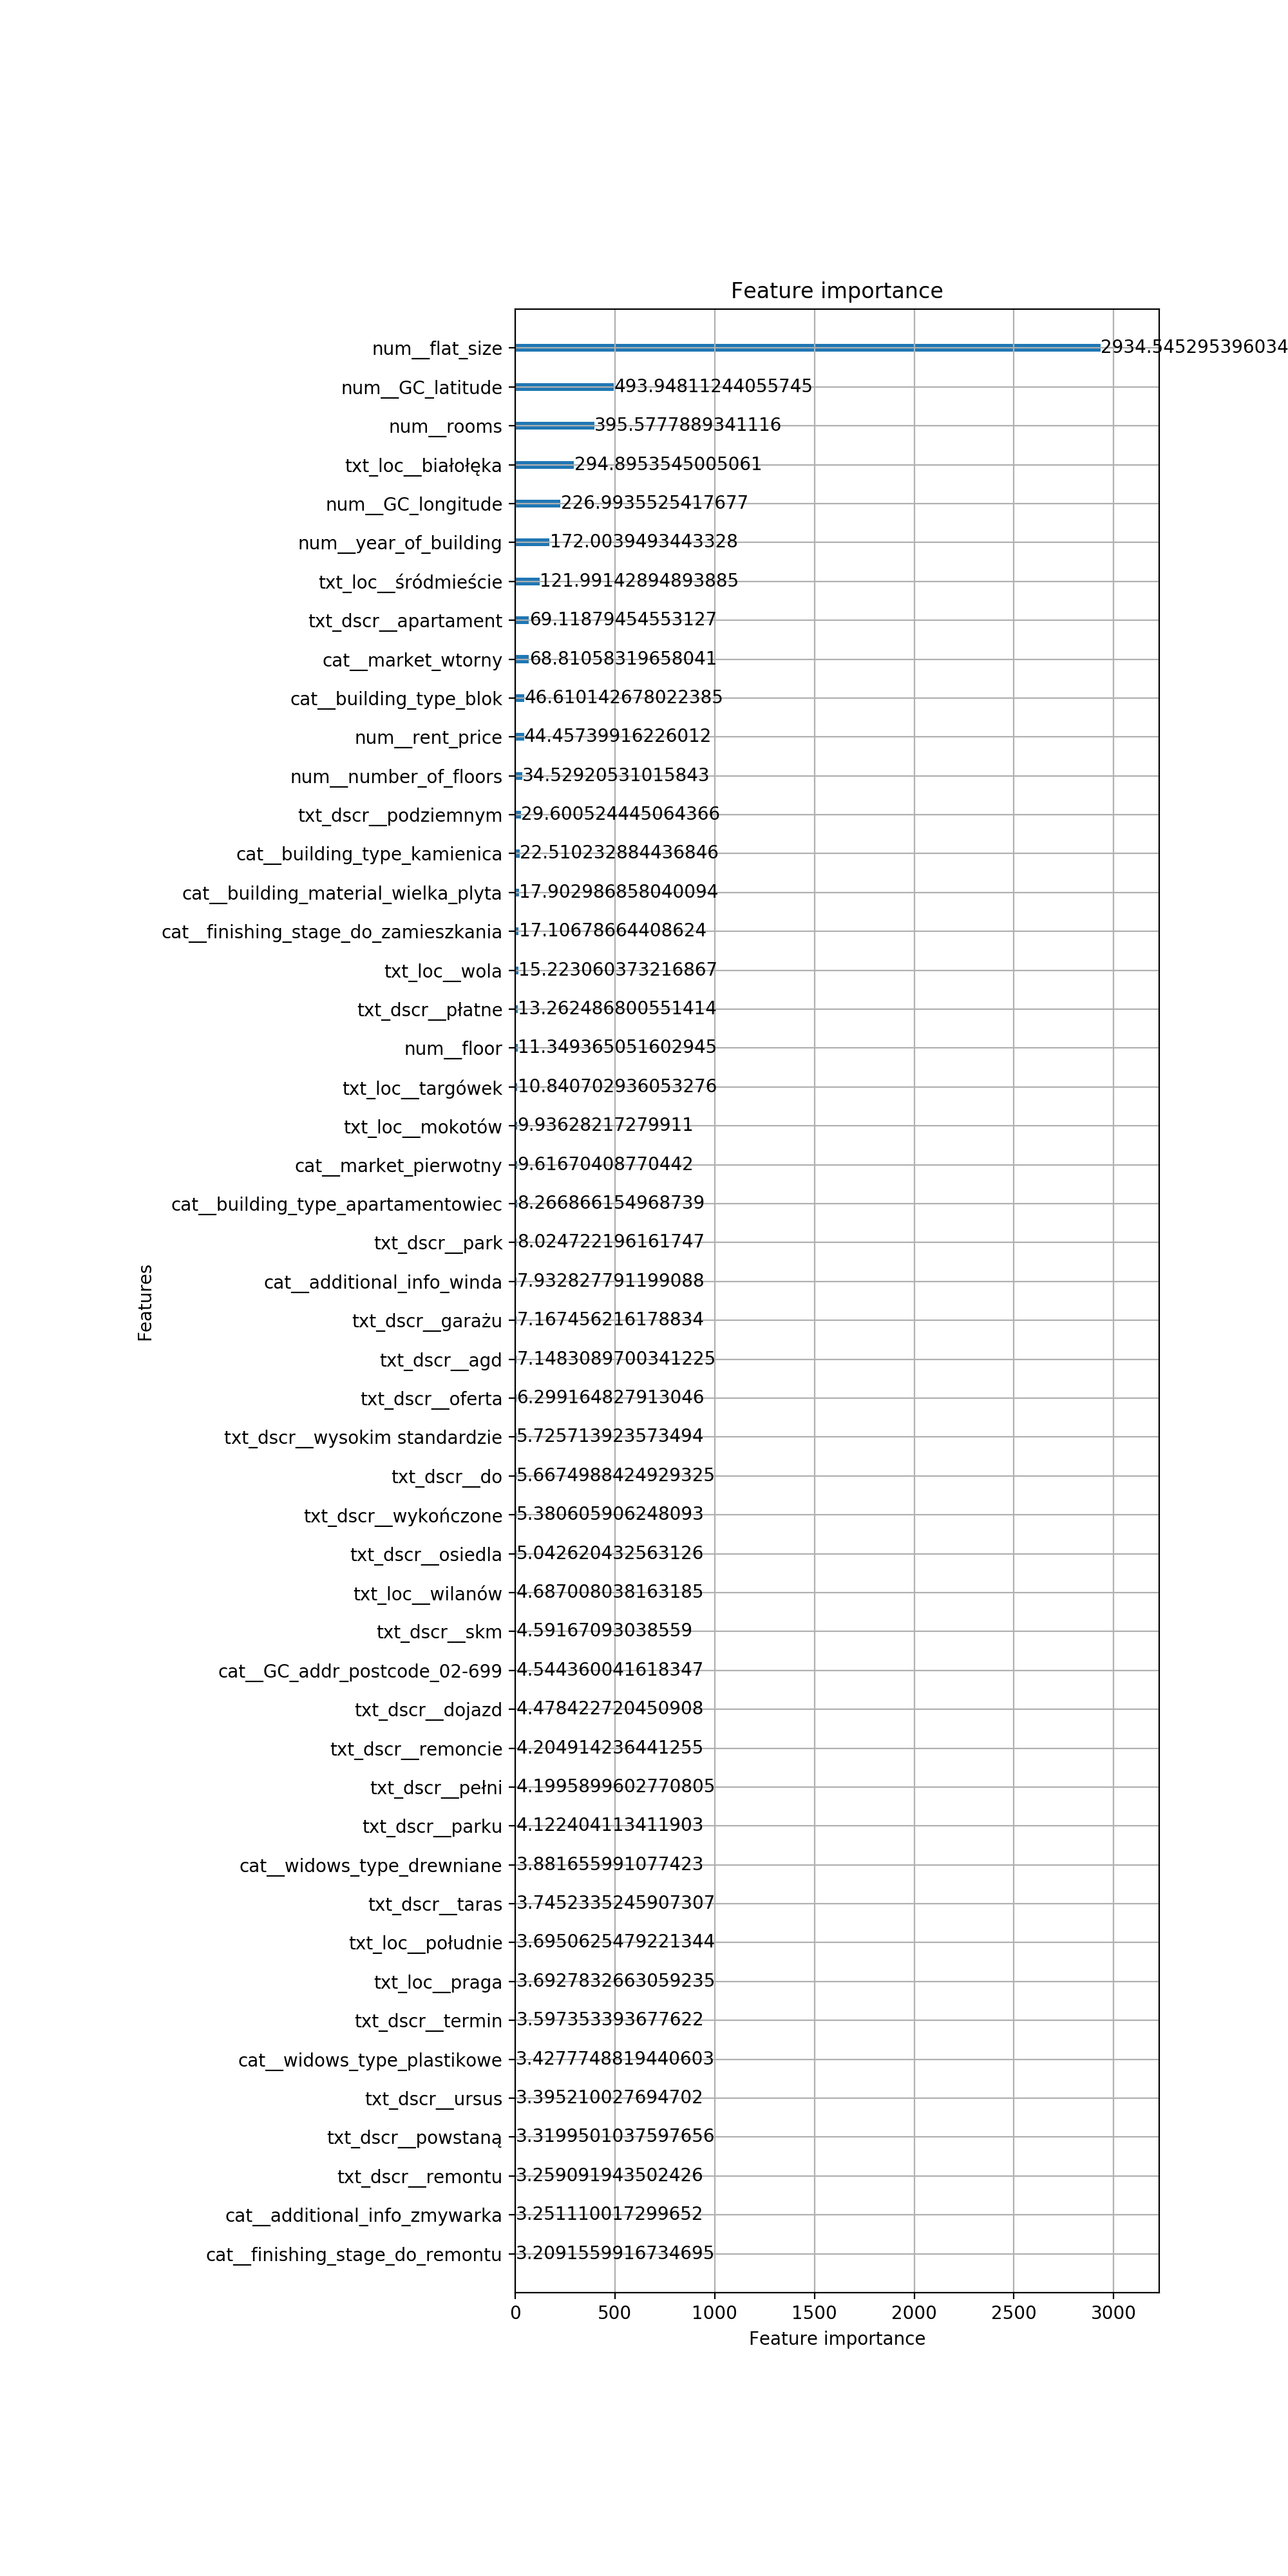

In [109]:
print('Plotting feature importances...')
def names(): return pipe_lgb.named_steps['columntransformer'].get_feature_names()
pipe_lgb.named_steps['lgbmregressor'].booster_.feature_name = names
fig, ax = plt.subplots(figsize=(10,20))
fig.subplots_adjust(left=0.4)
lgb.plot_importance(pipe_lgb.named_steps['lgbmregressor'], max_num_features=50, ax=ax, importance_type = 'gain')
plt.yticks(fontsize=10)
plt.show()